<a href="https://colab.research.google.com/github/sharsulkar/H1B_LCA_outcome_prediction/blob/main/prototyping/notebooks/PERM/03_sh_PERM_batch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import required libraries
import pandas as pd
import numpy as np
np.random.seed(42)
import random
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
import time
%matplotlib inline

In [2]:
def read_csv_to_list(filepath,header=None,squeeze=True):
  return list(pd.read_csv(filepath,header=None,squeeze=True))

In [3]:
#Custom transformer to drop rows based on filter
class droprows_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.row_index = None # row index to drop
      self.inplace=True
      self.reset_index=True

    def fit( self, X, y=None):
      return self 
    
    def transform(self, X, y=None):
      self.row_index=X[~X.CASE_STATUS.isin(['Certified','Denied'])].index
      X.drop(index=self.row_index,inplace=self.inplace)
      if self.reset_index:
        X.reset_index(inplace=True,drop=True)
      return X

In [4]:
class BuildFeaturesTransformer(BaseEstimator, TransformerMixin):
    """
    A class to build new features. 

    Args:
        input_columns (array or list) : The columns that will be used as input for building new features.

    Returns:
        DataFrame : Transformed dataframe with new features added in as columns
    """

    def __init__(self, input_columns):
        """
        Constructs all the necessary attributes for the BuildFeaturesTransformer object.

        Args:
            input_columns (array or list) : The columns that will be used as input for building new features.
        """
        self.input_columns = input_columns

    def date_diff(self, date1, date2):
        """
        Returns the difference between two input dates as timedelta.

        Args:
            date1 (datetime): A date
            date2 (datetime): Another date

        Returns:
            date_difference (timedelta): difference between date1 and date2
        """
        date_difference = pd.to_datetime(date1) -  pd.to_datetime(date2)
        return date_difference

    def is_usa(self, country):
        """
        Checks whether country is 'UNITED STATES OF AMERICA' or not and returns a binary flag

        Args:
            country (str): country

        Returns:
            USA_YN (str): binary flag based on country value
        """
        if country == 'UNITED STATES OF AMERICA':
            USA_YN = 'Y'
        else:
            USA_YN = 'N'
        return USA_YN

    def fit(self, X, y=None):
        """
        Fit the class on input dataframe

        Args:
            X (pandas DataFrame): input dataframe
            y : place holder, defaulted to None
        """
        return self

    def transform(self, X, y=None):
        """
        Apply transforms on the input dataframe to build new features

        Args:
            X (pandas DataFrame): input dataframe
            y : place holder, defaulted to None

        Returns:
            X : Transformed dataframe with new features added in as columns
        """
        # Processing_Days
        X['PROCESSING_DAYS'] = self.date_diff(X.DECISION_DATE, X.RECEIVED_DATE).dt.days
        
        # Employer_Worksite_YN
        X['EMPLOYER_WORKSITE_YN'] = 'Y'
        X.loc[X.EMPLOYER_POSTAL_CODE.ne(X.WORKSITE_POSTAL_CODE), 'EMPLOYER_WORKSITE_YN'] = 'N'

        # WAGE_ABOVE_PREVAILING_HR
        X['WAGE_PER_HR'] = X.WAGE_OFFER_FROM
        #compute for Year
        X.iloc[X[X.WAGE_OFFER_UNIT_OF_PAY == 'Year'].index, X.columns.get_loc('WAGE_PER_HR')] = X[X.WAGE_OFFER_UNIT_OF_PAY == 'Year'].WAGE_OFFER_FROM/2067
        #compute for Month
        X.iloc[X[X.WAGE_OFFER_UNIT_OF_PAY == 'Month'].index, X.columns.get_loc('WAGE_PER_HR')] = X[X.WAGE_OFFER_UNIT_OF_PAY == 'Month'].WAGE_OFFER_FROM/172
        #compute for Bi-weekly
        X.iloc[X[X.WAGE_OFFER_UNIT_OF_PAY == 'Bi-Weekly'].index, X.columns.get_loc('WAGE_PER_HR')] = X[X.WAGE_OFFER_UNIT_OF_PAY == 'Bi-Weekly'].WAGE_OFFER_FROM/80
        #compute for week
        X.iloc[X[X.WAGE_OFFER_UNIT_OF_PAY == 'Week'].index, X.columns.get_loc('WAGE_PER_HR')] = X[X.WAGE_OFFER_UNIT_OF_PAY == 'Week'].WAGE_OFFER_FROM/40

        #initialize with WAGE_RATE_OF_PAY_FROM
        X['PW_WAGE_PER_HR'] = X.PW_WAGE
        #compute for Year
        X.iloc[X[X.PW_UNIT_OF_PAY == 'Year'].index, X.columns.get_loc('PW_WAGE_PER_HR')] = X[X.PW_UNIT_OF_PAY == 'Year'].PW_WAGE/2067
        #compute for Month
        X.iloc[X[X.PW_UNIT_OF_PAY == 'Month'].index, X.columns.get_loc('PW_WAGE_PER_HR')] = X[X.PW_UNIT_OF_PAY == 'Month'].PW_WAGE/172
        #compute for Bi-weekly
        X.iloc[X[X.PW_UNIT_OF_PAY == 'Bi-Weekly'].index, X.columns.get_loc('PW_WAGE_PER_HR')] = X[X.PW_UNIT_OF_PAY == 'Bi-Weekly'].PW_WAGE/172
        #compute for Week
        X.iloc[X[X.PW_UNIT_OF_PAY == 'Week'].index, X.columns.get_loc('PW_WAGE_PER_HR')] = X[X.PW_UNIT_OF_PAY == 'Week'].PW_WAGE/172

        X['WAGE_ABOVE_PW_HR'] = X.WAGE_PER_HR-X.PW_WAGE_PER_HR

        #advertisement columns
        #NEWSPAPER_1
        X['NEWSPAPER_1'] = 'Y'
        X.iloc[X[X.FIRST_NEWSPAPER_NAME.isna()].index,X.columns.get_loc('NEWSPAPER_1')] = 'N'

        #NEWSPAPER_2
        X['NEWSPAPER_2'] = 'Y'
        X.iloc[X[X.SECOND_NEWSPAPER_AD_NAME.isna()].index,X.columns.get_loc('NEWSPAPER_2')] = 'N'

        #JOB_FAIR
        X['JOB_FAIR'] = 'Y'
        X.iloc[X[X.JOB_FAIR_FROM_DATE.isna()].index,X.columns.get_loc('JOB_FAIR')] = 'N'

        #ON_CAMPUS_RECRUITING
        X['ON_CAMPUS_RECRUITING'] = 'Y'
        X.iloc[X[X.ON_CAMPUS_RECRUITING_FROM_DATE.isna()].index,X.columns.get_loc('ON_CAMPUS_RECRUITING')] = 'N'

        #EMPLOYER_WEBSITE
        X['EMPLOYER_WEBSITE'] = 'Y'
        X.iloc[X[X.EMPLOYER_WEBSITE_FROM_DATE.isna()].index,X.columns.get_loc('EMPLOYER_WEBSITE')] = 'N'

        #PRO_ORG_AD
        X['PRO_ORG_AD'] = 'Y'
        X.iloc[X[X.PRO_ORG_AD_FROM_DATE.isna()].index,X.columns.get_loc('PRO_ORG_AD')] = 'N'

        #JOB_SEARCH_WEBSITE
        X['JOB_SEARCH_WEBSITE'] = 'Y'
        X.iloc[X[X.JOB_SEARCH_WEBSITE_FROM_DATE.isna()].index,X.columns.get_loc('JOB_SEARCH_WEBSITE')] = 'N'

        #PVT_EMPLOYMENT_FIRM
        X['PVT_EMPLOYMENT_FIRM'] = 'Y'
        X.iloc[X[X.PVT_EMPLOYMENT_FIRM_FROM_DATE.isna()].index,X.columns.get_loc('PVT_EMPLOYMENT_FIRM')] = 'N'

        #EMPLOYEE_REF_PROG
        X['EMPLOYEE_REF_PROG'] = 'Y'
        X.iloc[X[X.EMPLOYEE_REF_PROG_FROM_DATE.isna()].index,X.columns.get_loc('EMPLOYEE_REF_PROG')] = 'N'

        #CAMPUS_PLACEMENT
        X['CAMPUS_PLACEMENT'] = 'Y'
        X.iloc[X[X.CAMPUS_PLACEMENT_FROM_DATE.isna()].index,X.columns.get_loc('CAMPUS_PLACEMENT')] = 'N'

        #LOCAL_ETHNIC_PAPER
        X['LOCAL_ETHNIC_PAPER'] = 'Y'
        X.iloc[X[X.LOCAL_ETHNIC_PAPER_FROM_DATE.isna()].index,X.columns.get_loc('LOCAL_ETHNIC_PAPER')] = 'N'

        #RADIO_TV_AD
        X['RADIO_TV_AD'] = 'Y'
        X.iloc[X[X.RADIO_TV_AD_FROM_DATE.isna()].index,X.columns.get_loc('RADIO_TV_AD')] = 'N'


        return X


In [5]:
#Custom transformer to drop features for input feature list
class dropfeatures_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, inplace):
      self.columns = columns # list of categorical columns in input Dataframe
      self.inplace=True

    def fit( self, X, y=None):
      return self 
    
    def transform(self, X, y=None):
      X.drop(columns=self.columns,inplace=self.inplace)
      return X

In [6]:
#Custom transformer to compute Random Standard encoding for categorical features for incrementaly encoding data
class RSE_Transformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self, cat_cols, categories=None, RSE=None ):
        self.cat_cols = cat_cols # list of categorical columns in input Dataframe
        self.categories = None # Array of unique non-numeric values in each categorical column
        self.RSE = None # Array of Random Standard encoding for each row in categories
        
    def fit( self, X, y=None ):
      #Get a list of all unique categorical values for each column
      if self.categories is None:
        self.categories = [X[column].unique() for column in cat_cols]

        #replace missing values and append missing value label to each column to handle missing values in test dataset that might not be empty in train dataset
        for i in range(len(self.categories)):
          if np.array(self.categories[i].astype(str)!=str(np.nan)).all():
            self.categories[i]=np.append(self.categories[i],np.nan)

        #compute RandomStandardEncoding 
        self.RSE=[np.random.normal(0,1,len(self.categories[i])) for i in range(len(self.cat_cols))]

      else:
        for i in range(len(self.cat_cols)):
          #append new unique categories to self.categories
          new_categories=list(set(X[self.cat_cols[i]].unique()).difference(set(self.categories[i])))
          if new_categories!=[]:
            #print('not empty') #replace with logging call
            #print('categories before append',len(categories[i])) #logging call
            self.categories[i]=np.append(self.categories[i],new_categories) #append new categories to the end
            new_RSE=np.random.normal(0,1,len(new_categories)) #generate new RSE values
            #regenrate if overlap found with existing encodings
            if set(new_RSE).issubset(set(self.RSE[i])): 
              #print('yes') #loggin call
              new_RSE=np.random.normal(0,1,len(new_categories))
            
            self.RSE[i]=np.append(self.RSE[i],new_RSE) #append new RSE values
          #print('new categories',len(new_categories)) #logging call
          #print('categories after append',len(categories[i]))
     
      return self 
    
    def transform(self, X, y=None):
      for i in range(len(self.cat_cols)):
        #Temporary measure to handle previously unseen values
        #replace unseen values with NaN
        X.loc[X[~X[(str(self.cat_cols[i]))].isin(self.categories[i])].index,(str(self.cat_cols[i]))]=np.NaN

        #replace seen values with encoding
        X.loc[:,(str(self.cat_cols[i]))].replace(dict(zip(self.categories[i], self.RSE[i])),inplace=True)
      return X    

    def inverse_transform(self,X):
      for i in range(len(self.cat_cols)):
        X.loc[:,(str(self.cat_cols[i]))].replace(dict(zip(self.RSE[i], self.categories[i])),inplace=True)
      return X

In [7]:
#custom transformer for incrementally scaling to standard scale using pooled mean and variance
class CustomStandardScaler(BaseEstimator, TransformerMixin):
  def __init__(self,mean=None,var=None,n_samples_seen=None,scale=None):
    self.mean=None #mean
    self.var=None
    self.n_samples_seen=None
    self.scale=None

  def compute_sample_mean(self,X):
    return np.mean(X,axis=0)

  def compute_sample_var(self,X):
    return np.var(X,axis=0)

  def compute_sample_size(self,X):
    #assuming X is imputed, if there are null values, throw error aksing that X be imputed first
    return len(X)

  def compute_pooled_mean(self,X):
    #compute the sample mean and size
    sample_mean=self.compute_sample_mean(X)
    sample_count=self.compute_sample_size(X) 
    #compute pool mean
    pool_mean=(self.mean*self.n_samples_seen + sample_mean*sample_count)/(self.n_samples_seen + sample_count)

    return pool_mean

  def compute_pooled_var(self,X):
    #compute the sample var and size
    sample_var=self.compute_sample_var(X)
    sample_count=self.compute_sample_size(X) 
    #compute pool variance
    pool_var=(self.var*(self.n_samples_seen - 1) + sample_var*(sample_count - 1))/(self.n_samples_seen + sample_count - 2)

    return pool_var

  def fit(self,X):
    if self.mean is None:
      self.mean=self.compute_sample_mean(X)
    else: 
      self.mean=self.compute_pooled_mean(X)
    
    if self.var is None:
      self.var=self.compute_sample_var(X)
    else: 
      self.var=self.compute_pooled_var(X)

    if self.n_samples_seen is None:
      self.n_samples_seen=self.compute_sample_size(X) 
    else: 
      self.n_samples_seen+=self.compute_sample_size(X)
    return self

  def transform(self,X):
    return (X-self.mean)/np.sqrt(self.var)

  def inverse_transform(self,X):
    return X*np.sqrt(self.var) + self.mean



In [8]:
fe_cols=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/feature_engineering_columns_PERM.csv',header=None,squeeze=True)
drop_cols=read_csv_to_list('https://github.com/sharsulkar/H1B_LCA_outcome_prediction/raw/main/data/processed/drop_columns_PERM.csv',header=None,squeeze=True)
cat_cols=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/categorical_columns_PERM.csv',header=None,squeeze=True)
num_cols=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/numeric_columns_PERM.csv',header=None,squeeze=True)
required_features=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/required_features_PERM.csv',header=None,squeeze=True)

In [9]:
#Build preprocessing pipeline
build_feature_pipe=make_pipeline(
    droprows_Transformer(),
    BuildFeaturesTransformer(fe_cols)
    )

numerical_preprocess=make_pipeline(
    SimpleImputer(strategy='median'),
    CustomStandardScaler()
)
preprocess_pipe=make_column_transformer(
    (dropfeatures_Transformer(columns=drop_cols,inplace=True),drop_cols),
    (RSE_Transformer(cat_cols),cat_cols),
    (numerical_preprocess,num_cols),
    remainder='passthrough'
)
all_preprocess=make_pipeline(
    preprocess_pipe
)

In [ ]:
'''
#Import source data
fy21_df=pd.read_excel('/content/drive/MyDrive/Datasets/PERM_prediction/PERM_Disclosure_Data_FY2021_Q1.xlsx',usecols=required_features)
#fy21_dfcopy=fy21_df.copy()

fy20_df=pd.read_excel('/content/drive/MyDrive/Datasets/PERM_prediction/PERM_Disclosure_Data_FY2020.xlsx',usecols=required_features)
#fy20_dfcopy=fy20_df.copy()

fy19_df=pd.read_excel('/content/drive/MyDrive/Datasets/PERM_prediction/PERM_Disclosure_Data_FY2019_processed.xlsx')
#fy19_dfcopy=fy19_df.copy()

fy18_df=pd.read_csv('/content/drive/MyDrive/Datasets/PERM_prediction/PERM_Disclosure_Data_FY2018_processed.csv')
#fy18_dfcopy=fy18_df.copy()

#concat dataframes into a single dataset
frames=[fy21_df,fy20_df,fy19_df,fy18_df]
data_df=pd.concat(frames,ignore_index=True)
data_dfcopy=data_df.copy()

#one time operations - save the concat df to file for future use
data_df.to_csv('/content/drive/MyDrive/Datasets/PERM_prediction/PERM_Disclosure_Data_FY18_to_20.csv',index=False)
'''

In [17]:
data_df=pd.read_csv('/content/drive/MyDrive/Datasets/PERM_prediction/PERM_Disclosure_Data_FY18_to_20.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,52,53,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
data_df.head()

,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,REFILE,SCHD_A_SHEEPHERDER,EMPLOYER_POSTAL_CODE,FW_OWNERSHIP_INTEREST,PW_SKILL_LEVEL,PW_WAGE,PW_UNIT_OF_PAY,PW_WAGE_SOURCE,WAGE_OFFER_FROM,WAGE_OFFER_UNIT_OF_PAY,WORKSITE_POSTAL_CODE,MINIMUM_EDUCATION,REQUIRED_TRAINING,REQUIRED_EXPERIENCE,ACCEPT_ALT_FIELD_OF_STUDY,ACCEPT_ALT_COMBO,ACCEPT_FOREIGN_EDUCATION,ACCEPT_ALT_OCCUPATION,ACCEPT_ALT_OCCUPATION_MONTHS,JOB_OPP_REQUIREMENTS_NORMAL,FOREIGN_LANGUAGE_REQUIRED,COMBINATION_OCCUPATION,OFFERED_TO_APPL_FOREIGN_WORKER,FOREIGN_WORKER_LIVE_ON_PREM,FOREIGN_WORKER_LIVE_IN_DOM_SER,PROFESSIONAL_OCCUPATION,APP_FOR_COLLEGE_U_TEACHER,SUNDAY_EDITION_NEWSPAPER,FIRST_NEWSPAPER_NAME,SECOND_NEWSPAPER_AD_NAME,JOB_FAIR_FROM_DATE,ON_CAMPUS_RECRUITING_FROM_DATE,EMPLOYER_WEBSITE_FROM_DATE,PRO_ORG_AD_FROM_DATE,JOB_SEARCH_WEBSITE_FROM_DATE,PVT_EMPLOYMENT_FIRM_FROM_DATE,EMPLOYEE_REF_PROG_FROM_DATE,CAMPUS_PLACEMENT_FROM_DATE,LOCAL_ETHNIC_PAPER_FROM_DATE,RADIO_TV_AD_FROM_DATE,EMP_RECEIVED_PAYMENT,POSTED_NOTICE_AT_WORKSITE,LAYOFF_IN_PAST_SIX_MONTHS,COUNTRY_OF_CITIZENSHIP,FOREIGN_WORKER_BIRTH_COUNTRY,CLASS_OF_ADMISSION,FOREIGN_WORKER_EDUCATION,FOREIGN_WORKER_YRS_ED_COMP,FOREIGN_WORKER_ED_INST_COUNTRY,FOREIGN_WORKER_ALT_OCC_EXP,FOREIGN_WORKER_EXP_WITH_EMPL,FOREIGN_WORKER_EMPL_PAY_FOR_ED,FOREIGN_WORKER_CURR_EMPLOYED,EMPLOYER_COMPLETED_APPLICATION
0,Withdrawn,2019-06-27 00:00:00,2020-10-01 00:00:00,N,N,33166,N,Level III,40227.0,Year,OES,40227.0,Year,33166,High School,N,Y,N,N,Y,N,NaN,Y,N,N,Y,N,N,N,N,Y,Miami Herald,Miami Herald,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,Y,N,VENEZUELA,VENEZUELA,B-2,Bachelor's,1999.0,VENEZUELA,NaN,N,N,Y,Y
1,Denied,2019-07-17 00:00:00,2020-10-01 00:00:00,N,N,60606,N,Level III,96658.0,Year,OES,97000.0,Year,60606,Master's,N,N,N,Y,Y,Y,24.0,N,N,N,Y,N,N,Y,N,Y,Chicago Tribune,Chicago Tribune,NaN,NaN,NaN,NaN,2019-04-01 00:00:00,NaN,NaN,NaN,2019-04-05 00:00:00,2019-04-05 00:00:00,N,Y,Y,INDIA,INDIA,H-1B,Bachelor's,2004.0,INDIA,Y,N,N,Y,N
2,Certified,2019-12-16 00:00:00,2020-10-01 00:00:00,N,N,95014,N,Level I,96325.0,Year,OES,146000.0,Year,95014,Bachelor's,N,N,Y,N,Y,N,NaN,Y,N,N,Y,N,N,Y,N,Y,The Mercury News,The Mercury News,NaN,NaN,NaN,2019-08-01 00:00:00,2019-07-22 00:00:00,NaN,NaN,NaN,2019-07-26 00:00:00,NaN,N,Y,N,CHINA,CHINA,H-1B,Bachelor's,2015.0,UNITED STATES OF AMERICA,NaN,N,N,Y,N
3,Certified,2019-12-16 00:00:00,2020-10-01 00:00:00,N,N,95014,N,Level II,111634.0,Year,OES,134888.0,Year,95014,Master's,N,N,Y,N,Y,N,NaN,Y,N,N,Y,N,N,Y,N,Y,The Mercury News,The Mercury News,NaN,NaN,NaN,2019-09-01 00:00:00,2019-08-05 00:00:00,NaN,NaN,NaN,2019-08-09 00:00:00,NaN,N,Y,N,SOUTH KOREA,SOUTH KOREA,H-1B,Doctorate,2017.0,UNITED STATES OF AMERICA,NaN,N,N,Y,N
4,Certified,2019-12-11 00:00:00,2020-10-01 00:00:00,N,N,60601,N,Level IV,122138.0,Year,OES,190000.0,Year,60601,Bachelor's,N,N,Y,N,Y,Y,60.0,N,N,N,Y,N,N,Y,N,Y,Chicago Tribune,Chicago Tribune,NaN,NaN,NaN,NaN,2019-07-19 00:00:00,NaN,2019-07-09 00:00:00,NaN,2019-07-17 00:00:00,NaN,N,Y,N,UNITED KINGDOM,UNITED KINGDOM,H-1B,Bachelor's,2006.0,UNITED KINGDOM,Y,N,Y,Y,N


In [19]:
#create train and validation set
train_df,val_df=train_test_split(data_df,test_size=0.3,stratify=data_df['CASE_STATUS'])
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

In [ ]:
#fit_transform pipeline on training data
fe_df_train=build_feature_pipe.fit_transform(train_df)

#collection of indexes for both classes from the entire training dataset
class_0_index=fe_df_train[fe_df_train.CASE_STATUS=='Certified'].index 
class_1_index=fe_df_train[fe_df_train.CASE_STATUS=='Denied'].index
#skewness between classes - class 1 is only 7% of total
print('Class skew:',class_1_index.shape[0]*100/(class_0_index.shape[0]+class_1_index.shape[0]))

y_train=fe_df_train.pop('CASE_STATUS')
y_train.replace(['Certified','Denied'],[0,1],inplace=True)

X_train=all_preprocess.fit_transform(fe_df_train)

In [ ]:
#transform validation set
fe_df_val=build_feature_pipe.transform(val_df)
y_val=fe_df_val.pop('CASE_STATUS')
y_val.replace(['Certified','Denied'],[0,1],inplace=True)
X_val=all_preprocess.transform(fe_df_val)

In [22]:
rfc0=RandomForestClassifier(n_jobs=-1,random_state=42,n_estimators=1000)
#rfc1=RandomForestClassifier(n_jobs=-1,random_state=42,n_estimators=50)
#rfc2=RandomForestClassifier(n_jobs=-1,random_state=42,n_estimators=1000)
#rfc3=RandomForestClassifier(n_jobs=-1,random_state=42,max_depth=100)
#rfc4=RandomForestClassifier(n_jobs=-1,random_state=42,max_depth=500)

for model in [rfc0]:
  start = time.time()
  model.fit(X_train,y_train)
  model_score=f1_score(y_true=y_val,y_pred=model.predict(X_val),average=None)
  print(model_score)
  elapsed_time = (time.time() - start)
  #model_performance_df.loc[model_performance_df.shape[0]]=[str(model).split('(')[0],'test data',model_score[0],model_score[1],elapsed_time]
  

[0.97844792 0.70071643]


In [23]:
confusion_matrix(y_val,y_pred=model.predict(X_val))

array([[58792,   427],
       [ 2163,  3032]])

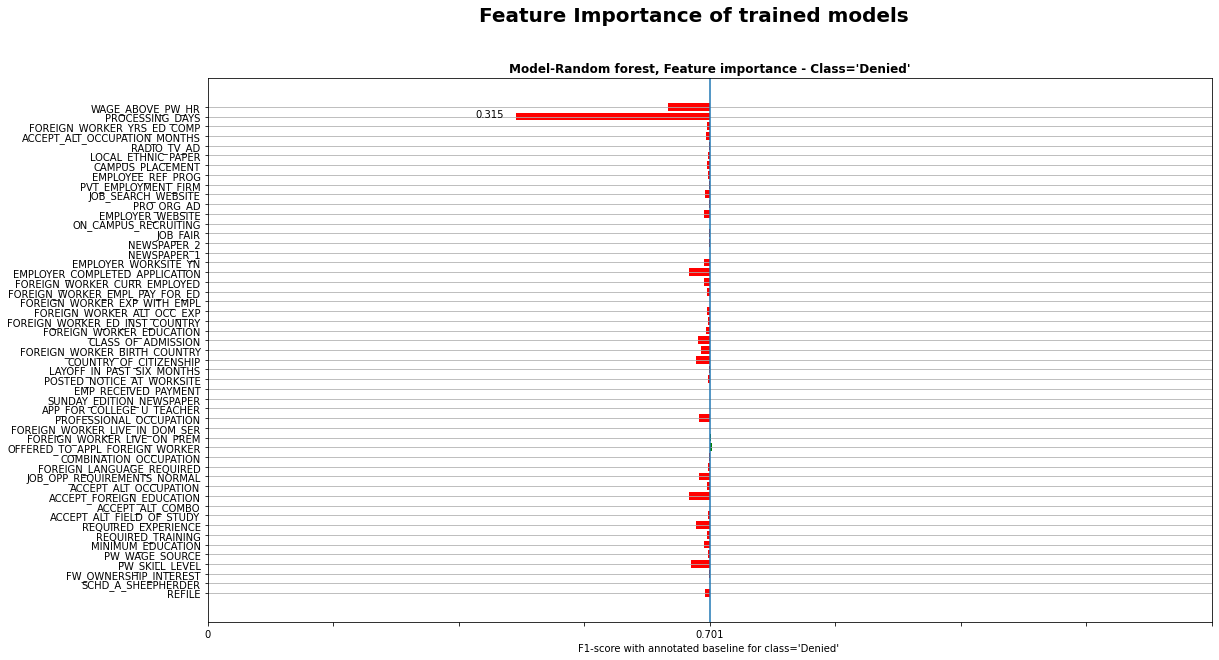

In [34]:
#for model in [svc,logistic,rfc,adaboost]:
j=0
fig = plt.figure(figsize=(18,10))
fig.suptitle('Feature Importance of trained models', fontsize=20, fontweight='bold')
model_name=['Random forest']
for model in [rfc0]: #,svc_rbf,svc_poly
#for model in [svc_rbf,svc_poly]:
  j+=1
  feature_importance_df=pd.DataFrame(columns=['model','feature','metrics','baseline_diff'])

  baseline=f1_score(y_true=y_val,y_pred=model.predict(X_val),average=None)
  #print('baseline: ',baseline)
  for i in range(X_val.shape[1]):
    hide_feature_map=np.ones((X_val.shape[1]))
    hide_feature_map[i]=0
    X_hide_map=hide_feature_map*X_val
    y_pred=model.predict(X_hide_map)
    feature_score=f1_score(y_true=y_val,y_pred=y_pred,average=None)
    feature_importance_df.loc[feature_importance_df.shape[0]]=[model_name[j-1],np.append(cat_cols,num_cols)[i],np.round(feature_score,3),np.round((feature_score-baseline),3)]
    #print('Feature removed: ',np.append(cat_cols,num_cols)[i],', metrics ',f1_score(y_true=y_test,y_pred=y_pred,average=None))
  
  class1_diff=np.array([feature_importance_df.baseline_diff.values[i][1] for i in range(X_val.shape[1])])
  class1_metric=np.array([feature_importance_df.metrics.values[i][1] for i in range(X_val.shape[1])])
  #fig = plt.figure(figsize=(15,10))
  ax = plt.subplot(1,1,j)
  ax.set_title('Model-' + model_name[j-1] + ', Feature importance - Class=\'Denied\'',fontweight='bold')
  ax.grid(True,axis='y')
  ax.set(xlim=(-1, 1))
  ax.set_xticklabels(['0','','','',str(round(baseline[1],3))])
  ax.set_xlabel('F1-score with annotated baseline for class=\'Denied\' ')
  ax.axvline(x=0)
  ax.barh(width=class1_diff,y=feature_importance_df.feature.values,color=['g' if class1_diff[i] > 0 else 'r' for i in range(len(class1_diff))])
  if j%2==0:
    plt.setp(ax, yticklabels=[])

  #annotate only if metric value changes overthreshold
  for i in range(len(class1_diff)) :
    if np.abs(class1_diff[i])>0.2:
      ax.annotate(str(class1_metric[i]), xy=(class1_diff[i], feature_importance_df.feature.values[i]),xytext=(class1_diff[i]-0.08, feature_importance_df.feature.values[i]))

#fig.savefig('/content/drive/MyDrive/H1B_model_importance_plot.png')

In [170]:
#check misclassified test samples
y_pred=pd.Series(model.predict(X_val),name=y_val.name)
#true=1, pred=0
misclassified_0=list(set(y_val[y_val==1].index.values).intersection(y_pred[y_pred==0].index.values))

In [75]:
#check the distribution of misclassification over distribution year and quarter
df=pd.DataFrame(data=np.transpose([np.array(misclassified_0),pd.to_datetime(fe_df_val.loc[misclassified_0,'DECISION_DATE']).dt.year.values,pd.to_datetime(fe_df_val.loc[misclassified_0,'DECISION_DATE']).dt.month.values,pd.to_datetime(fe_df_val.loc[misclassified_0,'DECISION_DATE']).dt.quarter.values]),
                columns=['index','year','month','quarter'])
df.groupby(['year','quarter']).size() 

year  quarter
2017  4          121
2018  1          141
      2          142
      3          273
      4          150
2019  1          158
      2          272
      3          189
      4          149
2020  1          122
      2          164
      3          168
      4          114
dtype: int64

In [110]:
def weightedL2(a, b, w):
    q = a-b
    return np.sqrt((w*q*q).sum())

In [ ]:
# find the closest samples between misclassified and correctly classified in the test set to see if that gives any insights
#true=1, pred=1
val_classified_1=list(set(y_val[y_val==1].index.values).intersection(y_pred[y_pred==1].index.values))

#create a grid of shape (len(misclassified_0),len(classified_1)) to store distance between each record
val_distance_grid=np.zeros((len(misclassified_0),len(val_classified_1)))

#decrease weights of some features so they have more preference to match
w=np.ones(X_val.shape[1])
variable_idx=[3,5,24,25,26,27,49] # index of variable fields where changes in values can impact outcome
#print(np.append(cat_cols,num_cols)[variable_idx])
w[variable_idx]=[0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#for each of the missclassified sample, find distance with each classified sample
for i in range(len(misclassified_0)):
  for j in range(len(val_classified_1)):
    val_distance_grid[i,j]=weightedL2(X_val[misclassified_0[i]],X_val[val_classified_1[j]],w)


In [157]:
#find distance between each misclassfied sample and training data for class 1
train_classified_1=list(y_train[y_train==1].index.values)

#create a grid of shape (len(misclassified_0),len(classified_1)) to store distance between each record
train_distance_grid=np.zeros((len(misclassified_0),len(train_classified_1)))

#decrease weights of some features so they have more preference to match
w=np.ones(X_val.shape[1])
variable_idx=[3,5,24,25,26,27,49] # index of variable fields where changes in values can impact outcome
#print(np.append(cat_cols,num_cols)[variable_idx])
w[variable_idx]=[0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#for each of the missclassified sample, find distance with each classified sample
for i in range(len(misclassified_0)):
  for j in range(len(train_classified_1)):
    train_distance_grid[i,j]=weightedL2(X_val[misclassified_0[i]],X_train[train_classified_1[j]],w)


In [198]:
#compare misclassified sample with its closest correctly classified sample from test set and training set
idx=50 #<-- change index here with value in range 0:len(misclassified_0)-1

#print the minimum distance between misclassified sample and closest correct classified sample
print('distance to closest correctly classified sample:',val_distance_grid[idx][np.argmin(val_distance_grid[idx])])

#print the minimum distance between misclassified sample and closest training data
print('distance to closest class 1 training sample:',train_distance_grid[idx][np.argmin(train_distance_grid[idx])])

#store the feature details in a df for user display -
#insert missclassified and closest correctly classified record from test set
compare_df=fe_df_val.loc[[misclassified_0[idx],val_classified_1[np.argmin(val_distance_grid[idx])]],np.append(cat_cols,num_cols)]
#insert closest record from training set where class=1
compare_df=compare_df.append(fe_df_train.loc[[train_classified_1[np.argmin(train_distance_grid[idx])]],np.append(cat_cols,num_cols)])

#reset and drop index
compare_df.reset_index(inplace=True,drop=True)

#add new index to highlight record type
compare_df['ROW_TYPE']=['Misclassification','Correct classification','Closest Class 1 training sample']
compare_df.set_index(['ROW_TYPE'],inplace=True)

#display the dataframe for selected sample
compare_df

distance to closest correctly classified sample: 0.5477618809568816
distance to closest class 1 training sample: 0.20737259021743362


,REFILE,SCHD_A_SHEEPHERDER,FW_OWNERSHIP_INTEREST,PW_SKILL_LEVEL,PW_WAGE_SOURCE,MINIMUM_EDUCATION,REQUIRED_TRAINING,REQUIRED_EXPERIENCE,ACCEPT_ALT_FIELD_OF_STUDY,ACCEPT_ALT_COMBO,ACCEPT_FOREIGN_EDUCATION,ACCEPT_ALT_OCCUPATION,JOB_OPP_REQUIREMENTS_NORMAL,FOREIGN_LANGUAGE_REQUIRED,COMBINATION_OCCUPATION,OFFERED_TO_APPL_FOREIGN_WORKER,FOREIGN_WORKER_LIVE_ON_PREM,FOREIGN_WORKER_LIVE_IN_DOM_SER,PROFESSIONAL_OCCUPATION,APP_FOR_COLLEGE_U_TEACHER,SUNDAY_EDITION_NEWSPAPER,EMP_RECEIVED_PAYMENT,POSTED_NOTICE_AT_WORKSITE,LAYOFF_IN_PAST_SIX_MONTHS,COUNTRY_OF_CITIZENSHIP,FOREIGN_WORKER_BIRTH_COUNTRY,CLASS_OF_ADMISSION,FOREIGN_WORKER_EDUCATION,FOREIGN_WORKER_ED_INST_COUNTRY,FOREIGN_WORKER_ALT_OCC_EXP,FOREIGN_WORKER_EXP_WITH_EMPL,FOREIGN_WORKER_EMPL_PAY_FOR_ED,FOREIGN_WORKER_CURR_EMPLOYED,EMPLOYER_COMPLETED_APPLICATION,EMPLOYER_WORKSITE_YN,NEWSPAPER_1,NEWSPAPER_2,JOB_FAIR,ON_CAMPUS_RECRUITING,EMPLOYER_WEBSITE,PRO_ORG_AD,JOB_SEARCH_WEBSITE,PVT_EMPLOYMENT_FIRM,EMPLOYEE_REF_PROG,CAMPUS_PLACEMENT,LOCAL_ETHNIC_PAPER,RADIO_TV_AD,ACCEPT_ALT_OCCUPATION_MONTHS,FOREIGN_WORKER_YRS_ED_COMP,PROCESSING_DAYS,WAGE_ABOVE_PW_HR
ROW_TYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Misclassification,NaN,N,N,Level III,OES,High School,N,Y,N,N,Y,N,Y,N,N,Y,N,N,N,N,Y,N,Y,N,BRAZIL,BRAZIL,F-1,High School,NaN,NaN,NaN,NaN,NaN,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,NaN,1993.0,240,0.000000
Correct classification,NaN,N,N,Level IV,OES,High School,N,Y,N,N,Y,N,Y,N,N,Y,N,N,N,N,Y,N,Y,N,BRAZIL,BRAZIL,B-2,High School,NaN,NaN,NaN,NaN,NaN,N,N,Y,Y,N,N,N,N,N,N,N,N,N,N,NaN,2012.0,242,0.000000
Closest Class 1 training sample,N,N,N,Level III,OES,High School,N,Y,N,N,Y,N,Y,N,N,Y,N,N,N,N,Y,N,Y,N,BRAZIL,BRAZIL,H-1B,High School,NaN,NaN,NaN,NaN,NaN,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,NaN,1989.0,190,4.045477
